This notebook analyzes load profile.

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from utils import format_dispatch_ax, select_time_period, create_season_day_index

In [2]:
raw_data = os.path.join('data', 'guinea', 'raw_data')

main_folder = os.path.join(raw_data, '..', 'load')
if not os.path.exists(main_folder):
    os.makedirs(main_folder)

In [3]:

data = pd.read_csv(os.path.join(raw_data, 'data_guinea_load.csv'), header=[0], index_col=[0, 1, 2])
data


2017      2018      2019      2021      2022
season day hour                                                  
1      1   0     0.670057  0.696623  0.696623  0.567236  0.632307
           1     0.634161  0.667756  0.667756  0.577085  0.613796
           2     0.620102  0.655501  0.655501  0.502714  0.593063
           3     0.607837  0.630719  0.630719  0.492663  0.597038
           4     0.595573  0.613290  0.613290  0.488844  0.590413
...                   ...       ...       ...       ...       ...
12     31  19    0.910111  0.861928  0.861928  0.844221  0.854638
           20    0.914149  0.904412  0.904412  0.864925  0.891076
           21    0.911008  0.862745  0.862745  0.842814  0.873733
           22    0.891265  0.773148  0.773148  0.848241  0.818589
           23    0.634610  0.635893  0.635893  0.791357  0.769680

[8760 rows x 5 columns]

## Plot load profile

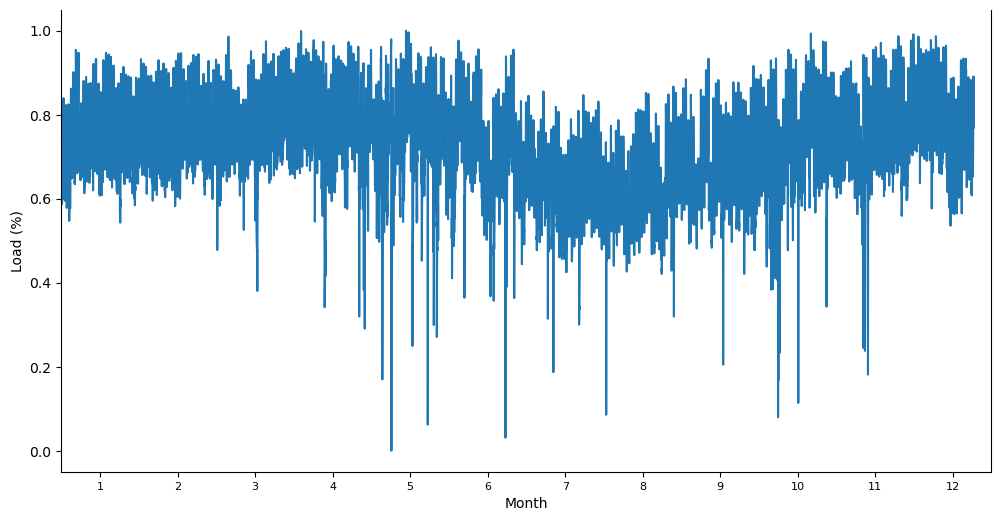

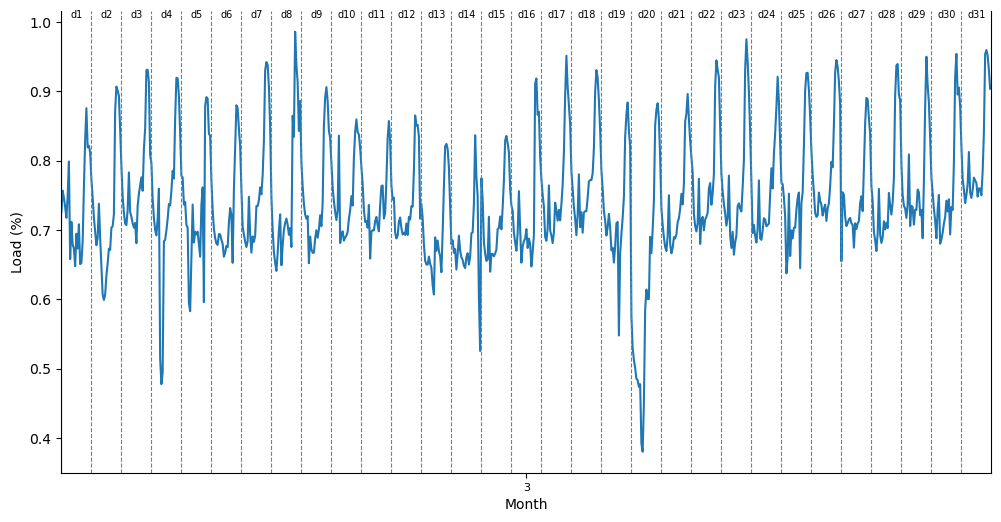

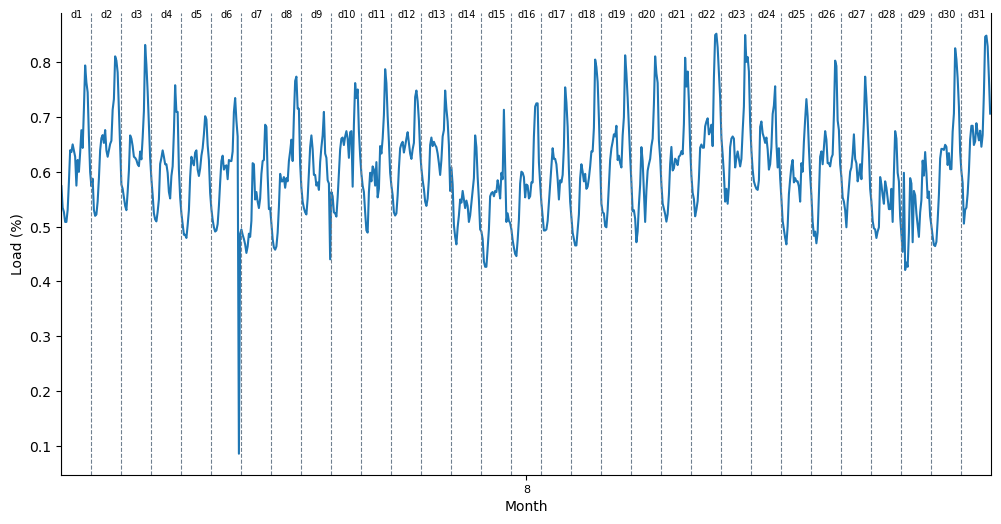

In [4]:
df = data.loc[:, '2022']
fig, ax = plt.subplots(figsize=(12, 6))
df.plot(ax=ax)
format_dispatch_ax(ax, df.index, day='day', display_day=False)
ax.set_ylabel('Load (%)')
ax.set_xlabel('Month')
plt.savefig(os.path.join(main_folder, 'dispatch_not_corrected.png'))

select_time = {'season': [3]}
df_select = select_time_period(df, select_time)
fig, ax = plt.subplots(figsize=(12, 6))
df_select.plot(ax=ax)
format_dispatch_ax(ax, df_select.index, day='day', display_day=True)
ax.set_ylabel('Load (%)')
ax.set_xlabel('Month')
plt.savefig(os.path.join(main_folder, 'dispatch_3_not_corrected.png'))

select_time = {'season': [8]}
df_select = select_time_period(df, select_time)
fig, ax = plt.subplots(figsize=(12, 6))
df_select.plot(ax=ax)
format_dispatch_ax(ax, df_select.index, day='day', display_day=True)
ax.set_ylabel('Load (%)')
ax.set_xlabel('Month')
plt.savefig(os.path.join(main_folder, 'dispatch_8_not_corrected.png'))

## Analyze load profile

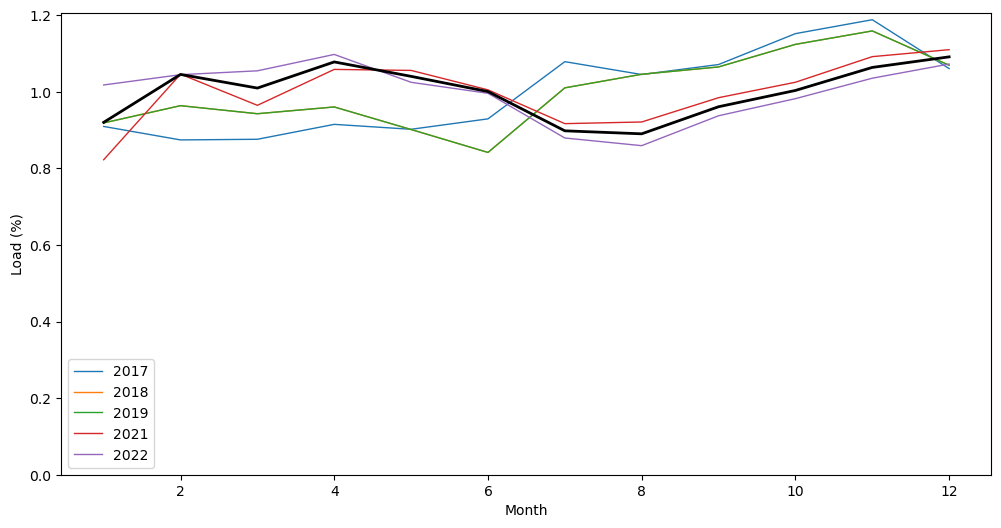

In [5]:
# Evolution of load seasonality
temp = data.groupby(['season']).mean()
fig, ax = plt.subplots(figsize=(12, 6))
temp = temp / temp.mean()
coefficient_month = temp.loc[:, ['2021', '2022']].mean(axis=1)
temp.plot(ax=ax, linewidth=1)
coefficient_month.plot(ax=ax, color='black', linewidth=2)
ax.set_ylabel('Load (%)')
ax.set_xlabel('Month')
# set bottom to 0
ax.set_ylim(bottom=0)
plt.savefig(os.path.join(main_folder, 'coefficient_month.png'))



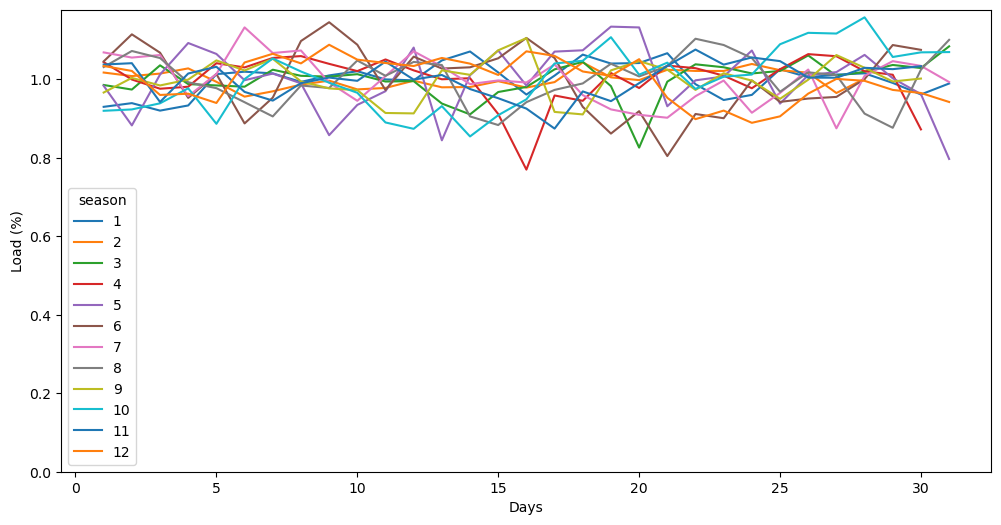

In [6]:
# Evolution of day seasonality - check to get weekdays and weekend
temp = data.loc[:, '2022']
temp = temp.groupby(['season', 'day']).mean()
temp = temp.unstack('season') / temp.groupby('season').mean()
fig, ax = plt.subplots(figsize=(12, 6))
temp.plot(ax=ax)
ax.set_ylabel('Load (%)')
ax.set_xlabel('Days')
# set bottom to 0
ax.set_ylim(bottom=0)
plt.savefig(os.path.join(main_folder, 'daily_average.png'))

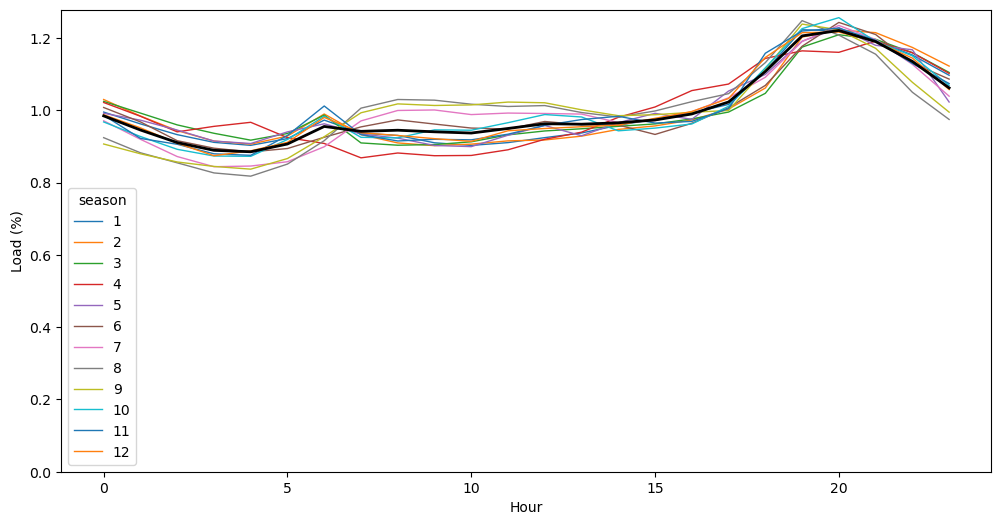

In [7]:
# Evolution of hour seasonality
temp = data.loc[:, '2022']
temp = temp.groupby(['season', 'hour']).mean()
temp = temp.unstack('season') / temp.groupby('season').mean()
coefficent_hour = temp.mean(axis=1)
fig, ax = plt.subplots(figsize=(12, 6))
temp.plot(ax=ax, linewidth=1)
coefficent_hour.plot(ax=ax, color='black', linewidth=2)
ax.set_ylabel('Load (%)')
ax.set_xlabel('Hour')
# set bottom to 0
ax.set_ylim(bottom=0)
plt.savefig(os.path.join(main_folder, 'coefficient_hour.png'))

## Generate synthetic load profile

In [8]:
coefficent_hour_norm = coefficent_hour / coefficent_hour.max()
coefficient_month_norm = coefficient_month / coefficient_month.max()

# Combine the two coefficient
series1, series2 = coefficent_hour_norm, coefficient_month_norm
index_combinations = list(product(series1.index, series2.index))
product_values = [series1[i1] * series2[i2] for i1, i2 in index_combinations]
multi_index = pd.MultiIndex.from_tuples(index_combinations, names=series1.index.names + series2.index.names)
product_series = pd.Series(product_values, index=multi_index)

# Add days of the week as another dimension
days = create_season_day_index()
product_series = (product_series * days)
product_series = product_series.reorder_levels(['season', 'day', 'hour'])
product_series = product_series.sort_index()

# Normalize the product series
if False:
    coeff_year = data.loc[:, '2022'].sum() / product_series.sum()
    product_series *= coeff_year
else:
    product_series = product_series / product_series.max()

# Save the product series
product_series.to_csv(os.path.join(main_folder, 'load_data_synthetic.csv'))

#### Plot synthetic load profile

(0.0, 0.8902182385999999)

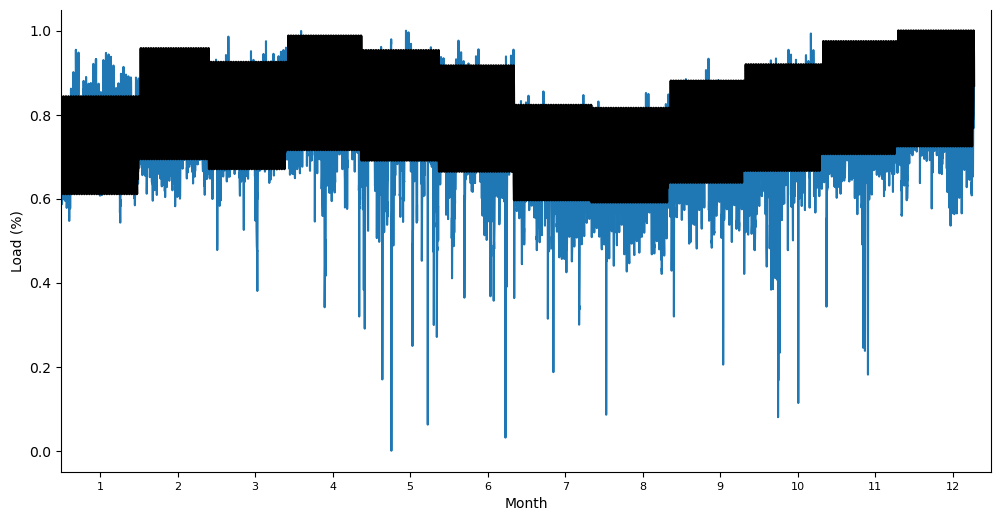

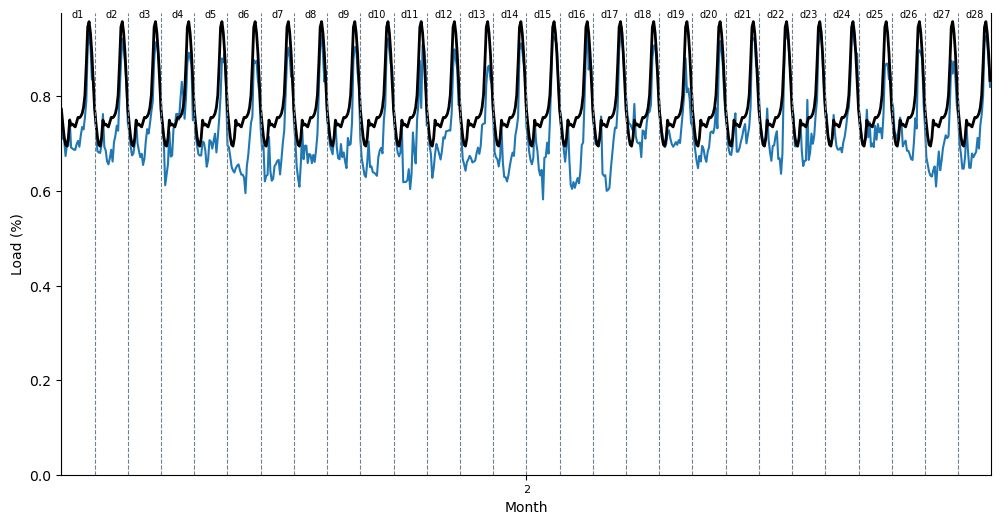

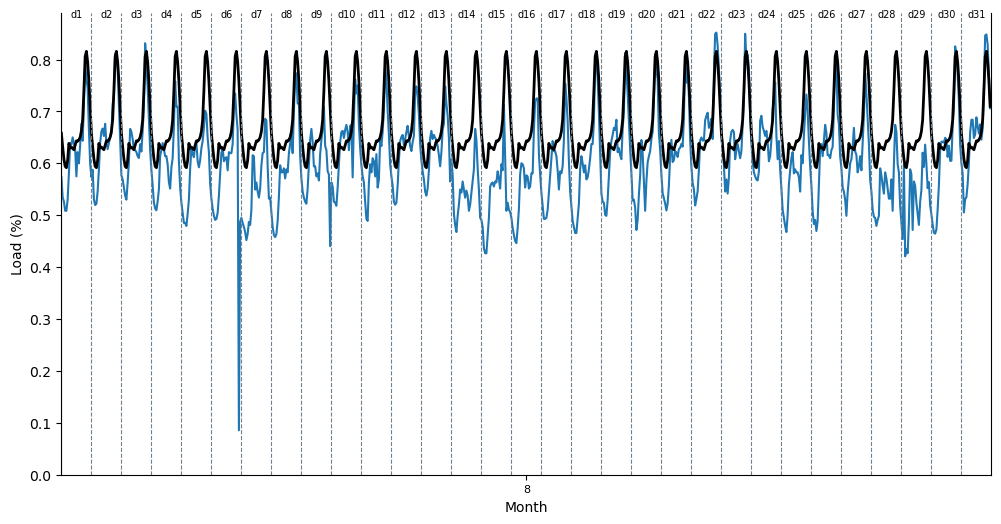

In [9]:
df = data.loc[:, '2022'].copy()
fig, ax = plt.subplots(figsize=(12, 6))
df.plot(ax=ax)
product_series.plot(ax=ax, color='black', linewidth=2)
format_dispatch_ax(ax, df.index, day='day', display_day=False)
ax.set_ylabel('Load (%)')
ax.set_xlabel('Month')

select_time = {'season': [2]}
df_select = select_time_period(df, select_time)
product_series_select = select_time_period(product_series, select_time)
fig, ax = plt.subplots(figsize=(12, 6))
df_select.plot(ax=ax)
product_series_select.plot(ax=ax, color='black', linewidth=2)
format_dispatch_ax(ax, df_select.index, day='day', display_day=True)
ax.set_ylabel('Load (%)')
ax.set_xlabel('Month')
ax.set_ylim(bottom=0)

select_time = {'season': [8]}
df_select = select_time_period(df, select_time)
product_series_select = select_time_period(product_series, select_time)
fig, ax = plt.subplots(figsize=(12, 6))
df_select.plot(ax=ax)
product_series_select.plot(ax=ax, color='black', linewidth=2)
format_dispatch_ax(ax, df_select.index, day='day', display_day=True)
ax.set_ylabel('Load (%)')
ax.set_xlabel('Month')
ax.set_ylim(bottom=0)